#PhlyGreen Tutorial 

Import packages

In [1]:
import sys
sys.path.insert(0,'../')
import PhlyGreen as pg
import numpy as np
import matplotlib.pyplot as plt

Create instances of subsystems. Each one of those requires an Aircraft object as argument. By passing (None) as argument, we are creating empty objects (for the moment).

In [2]:
powertrain = pg.Systems.Powertrain.Powertrain(None)
structures = pg.Systems.Structures.Structures(None)
aerodynamics = pg.Systems.Aerodynamics.Aerodynamics(None)
performance = pg.Performance.Performance(None)
mission = pg.Mission.Mission(None)
weight = pg.Weight.Weight(None)
constraint = pg.Constraint.Constraint(None)
welltowake = pg.WellToWake.WellToWake(None)
battery = pg.Systems.Battery.Battery(None)
climateimpact = pg.ClimateImpact.ClimateImpact(None)

Create instance of Aircraft object.

In [3]:
myaircraft = pg.Aircraft(powertrain, structures, aerodynamics, performance, mission, weight, constraint, welltowake, battery, climateimpact)

Create the connections with its subsystems.

In [4]:
powertrain.aircraft = myaircraft
structures.aircraft = myaircraft
aerodynamics.aircraft = myaircraft
mission.aircraft = myaircraft
performance.aircraft = myaircraft
weight.aircraft = myaircraft
constraint.aircraft = myaircraft
welltowake.aircraft = myaircraft
battery.aircraft = myaircraft

Define input dictionaries

Constraints ordering:
[0] : cruise,
[1] : take-off,
[2] : climb,
[3] : turn,
[4] : ceiling,
[5] : acceleration,
[6] : landing 

In [ ]:
ConstraintsInput = {'Cruise': {'Speed': 0.4, 'Speed Type':'Mach', 'Beta': 0.95, 'Altitude': 8000.},
         'AEO Climb': {'Speed': 170, 'Speed Type':'KCAS', 'Beta': 0.97, 'Altitude': 6000., 'ROC': 5},
         'OEI Climb': {'Speed': 104*1.2, 'Speed Type': 'KCAS', 'Beta': 1., 'Altitude': 0., 'Climb Gradient': 0.021},
         'Take Off': {'Speed': 140, 'Speed Type': 'KCAS', 'Beta': 0.985, 'Altitude': 100., 'kTO': 1.2, 'sTO': 950},
         'Landing':{'Speed': 104., 'Speed Type': 'KCAS', 'Altitude': 0.},
         'Turn':{'Speed': 210, 'Speed Type': 'KCAS', 'Beta': 0.9, 'Altitude': 5000, 'Load Factor': 1.1},
         'Ceiling':{'Speed': 0.5, 'Beta': 0.8, 'Altitude': 9500, 'HT': 0.5},
         'Acceleration':{'Mach 1': 0.3, 'Mach 2':0.4, 'DT': 180, 'Altitude': 6000, 'Beta': 0.9},
         'DISA': 0}

In [6]:
MissionInput = {'Range Mission': 750,  #nautical miles
                'Range Diversion': 220,  #nautical miles
                'Beta start': 0.985,
                'Payload Weight': 4560,  #Kg
                'Crew Weight': 500}  #Kg

In [7]:
MissionStages = {'Takeoff': {'Supplied Power Ratio':{'phi': 0.0}},
                 'Climb1': {'type': 'ConstantRateClimb', 'input': {'CB': 0.12, 'Speed': 77, 'StartAltitude': 100, 'EndAltitude': 1500}, 'Supplied Power Ratio':{'phi_start': 0.0, 'phi_end':0.0 }},
                 'Climb2': {'type': 'ConstantRateClimb', 'input': {'CB': 0.06, 'Speed': 110, 'StartAltitude': 1500, 'EndAltitude': 4500}, 'Supplied Power Ratio':{'phi_start': 0.0, 'phi_end':0.0 }},
                 'Climb3': {'type': 'ConstantRateClimb', 'input': {'CB': 0.05, 'Speed': 110, 'StartAltitude': 4500, 'EndAltitude': 8000}, 'Supplied Power Ratio':{'phi_start': 0.0, 'phi_end':0.0 }},
                 'Cruise': {'type': 'ConstantMachCruise', 'input':{ 'Mach': 0.45, 'Altitude': 8000}, 'Supplied Power Ratio':{'phi_start': 0.0, 'phi_end':0.0}},
                 'Descent1': {'type': 'ConstantRateDescent', 'input':{'CB': -0.04, 'Speed': 90, 'StartAltitude': 8000, 'EndAltitude': 200}, 'Supplied Power Ratio':{'phi_start': 0.0, 'phi_end':0.0 }}}

DiversionStages = {'Climb1': {'type': 'ConstantRateClimb', 'input': {'CB': 0.06, 'Speed': 110, 'StartAltitude': 200, 'EndAltitude': 3100}, 'Supplied Power Ratio':{'phi_start': 0.0, 'phi_end':0.0 }},
                 'Cruise': {'type': 'ConstantMachCruise', 'input':{ 'Mach': 0.2, 'Altitude': 3100}, 'Supplied Power Ratio':{'phi_start': 0.0, 'phi_end':0.0}},
                 'Descent1': {'type': 'ConstantRateDescent', 'input':{'CB': -0.04, 'Speed': 90, 'StartAltitude': 3100, 'EndAltitude': 200}, 'Supplied Power Ratio':{'phi_start': 0.0, 'phi_end':0.0 }}}

In [8]:
EnergyInput = {'Ef': 43.5*10**6,
                   'Contingency Fuel': 130,
                   'Eta Gas Turbine Model': 'PW127',
                   #'Eta Gas Turbine': 0.22,
                   'Eta Gearbox': 0.96,
                   'Eta Propulsive Model': 'constant',
                   'Eta Propulsive': 0.75,
                   'Specific Power Powertrain': [3900,7700],  # W/Kg
                   'Eta Electric Motor 1': 0.96,    #for serial config
                   'Eta Electric Motor 2': 0.96,    #for serial config
                   'Eta Electric Motor': 0.98,      #for parallel config
                   'Specific Power PMAD': [2200,2200,2200],
                   'PowertoWeight Powertrain': [150,33],
                   'PowertoWeight PMAD': 0,
                   'Eta PMAD': 0.99,
                   }

What follows is the battery cell input. Not used in this example.

In [9]:
CellInput = {
    'Class': "I",
    'Model':'Finger-Cell-Thermal',
    'SpecificPower': 8000,
    'SpecificEnergy': 1500,
    'Minimum SOC': 0.2,
    'Pack Voltage':800,
    'Initial temperature': 25,
    'Max operative temperature':50,
    'Ebat': 1000 * 3600, # PhlyGreen uses this input only if Class == 'I'
    'pbat': 1000
    }

In [10]:
AerodynamicsInput = {'NumericalPolar': {'type': 'ATR42'},
                    'Take Off Cl': 1.9,
                     'Landing Cl': 1.9,
                     'Minimum Cl': 0.20,
                     'Cd0': 0.017}

Import input dictionaries

In [11]:
myaircraft.ConstraintsInput = ConstraintsInput
myaircraft.AerodynamicsInput = AerodynamicsInput
myaircraft.MissionInput = MissionInput
myaircraft.MissionStages = MissionStages
myaircraft.DiversionStages = DiversionStages
myaircraft.EnergyInput = EnergyInput
myaircraft.CellInput = CellInput

Set aircraft power configuration

In [12]:
myaircraft.Configuration = 'Traditional'
#myaircraft.Configuration = 'Hybrid'
#myaircraft.HybridType = 'Parallel'
myaircraft.AircraftType = 'ATR'

Set inputs

In [13]:
# Initialize Constraint Analysis
myaircraft.constraint.SetInput()

# Initialize Mission profile and Analysis
myaircraft.mission.InitializeProfile()
myaircraft.mission.SetInput()

# Initialize Aerodynamics subsystem
myaircraft.aerodynamics.SetInput()

# Initialize Powertrain
myaircraft.powertrain.SetInput()

# Initialize Weight Estimator
myaircraft.weight.Class = 'I'

from FLOPS_input import FLOPS_input
myaircraft.FLOPSInput = FLOPS_input

myaircraft.weight.SetInput()

#Initialize Battery Configurator
myaircraft.battery.SetInput()

/Users/riccardo/opt/anaconda3/envs/phlygreen/lib/python3.12/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator LinearRegression from version 1.3.0 when using version 1.3.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Either run the Constraint Analysis....

In [14]:
myaircraft.constraint.FindDesignPoint()
print('----------------------------------------')
print('Design W/S: ',myaircraft.DesignWTOoS)
print('Design P/W: ',myaircraft.DesignPW)
print('----------------------------------------')

----------------------------------------
Design W/S:  3328.8528528528527
Design P/W:  168.51352203046332
----------------------------------------


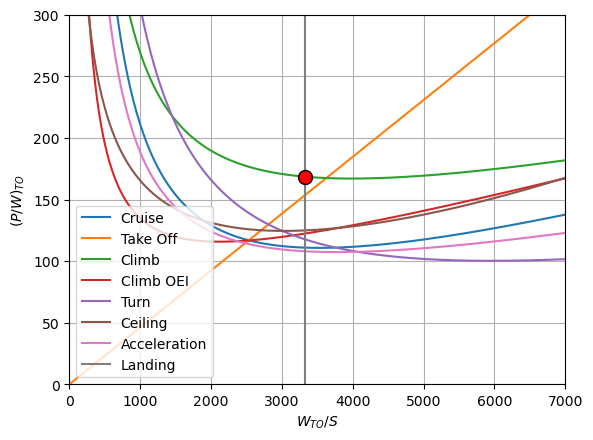

In [15]:
plt.plot(myaircraft.constraint.WTOoS,myaircraft.constraint.PWCruise, label='Cruise')
plt.plot(myaircraft.constraint.WTOoS,myaircraft.constraint.PWTakeOff, label='Take Off')
plt.plot(myaircraft.constraint.WTOoS,myaircraft.constraint.PWAEOClimb, label='Climb')
plt.plot(myaircraft.constraint.WTOoS,myaircraft.constraint.PWOEIClimb, label='Climb OEI')
plt.plot(myaircraft.constraint.WTOoS,myaircraft.constraint.PWTurn, label='Turn')
plt.plot(myaircraft.constraint.WTOoS,myaircraft.constraint.PWCeiling, label='Ceiling')
plt.plot(myaircraft.constraint.WTOoS,myaircraft.constraint.PWAcceleration, label='Acceleration')
plt.plot(myaircraft.constraint.WTOoSLanding,myaircraft. constraint.PWLanding, label='Landing')
plt.plot(myaircraft.DesignWTOoS, myaircraft.DesignPW, marker='o', markersize = 10, markerfacecolor = 'red', markeredgecolor = 'black')
# plt.plot(performance.WTOoSTorenbeek, performance.PWTorenbeek, label='Torenbeek')
plt.ylim([0, 300])
plt.xlim([0, 7000])
plt.legend()
plt.grid(visible=True)
plt.xlabel('$W_{TO}/S$')
plt.ylabel('$(P/W)_{TO}$')
plt.show()

... or assign a wing loading. As a matter of fact, the constraint analysis gives only a rough estimate of the required propulsive power, upon which grounding the wing loading choice. The mission analysis will give more accurate estimates (but requires a wing loading)

In [61]:
#myaircraft.DesignWTOoS = 3300

Run Mission analysis to define the aircraft's masses

In [16]:
myaircraft.weight.WeightEstimation()

Wing surface can be readily estimated as S = WTO/(WTO/S)

In [17]:
myaircraft.WingSurface = myaircraft.weight.WTO / myaircraft.DesignWTOoS * myaircraft.performance.g_acc 

A summary of the preliminary design:

In [18]:
myaircraft.Print_Aircraft_Design_Summary()

Fuel mass (trip + altn + loiter): 2066.6 [Kg]
Block Fuel mass:                  2196.6 [Kg]
Structure:                        10295.2 [Kg]
Powertrain mass:                  1016.0 [Kg]
Empty Weight:                     11811.3 [Kg]
Zero Fuel Weight:                 16371.3 [Kg]
----------------------------------------
Takeoff Weight:                   18567.9 [Kg]
 
 
Wing Surface:                     54.7 [m^2]
 
TakeOff engine shaft peak power:  3962.5 [KW]
CLB/CRZ engine shaft peak power:  3298.0 [KW] @ 1499.6 [m]
 
Sizing phase for thermal powertrain:  Takeoff peak power
Thermal powertrain rating shaft power SLS rating: 3962.5 [kW]
 


Some plots:

In [65]:
times = np.array([])
Ef = np.array([])
beta = np.array([])
for array in mission.integral_solution:
    times = np.concatenate([times, array.t])
    Ef = np.concatenate([Ef, array.y[0]])
    beta = np.concatenate([beta, array.y[1]])

Take-Off Propulsive Power over Takeoff Mass

In [66]:
myaircraft.performance.TakeOff(myaircraft.DesignWTOoS,myaircraft.constraint.TakeOffConstraints['Beta'], myaircraft.constraint.TakeOffConstraints['Altitude'],myaircraft.constraint.TakeOffConstraints['kTO'], myaircraft.constraint.TakeOffConstraints['sTO'], myaircraft.constraint.DISA, myaircraft.constraint.TakeOffConstraints['Speed'], myaircraft.constraint.TakeOffConstraints['Speed Type'])

153.65125462054286

Maximum mission Propusive Power over Takeoff Mass

In [67]:
max([myaircraft.performance.PoWTO(myaircraft.DesignWTOoS,beta[t],myaircraft.mission.profile.PowerExcess(times[t]),1,myaircraft.mission.profile.Altitude(times[t]),myaircraft.mission.DISA,myaircraft.mission.profile.Velocity(times[t]),'TAS') for t in range(len(times))])

127.886803505666

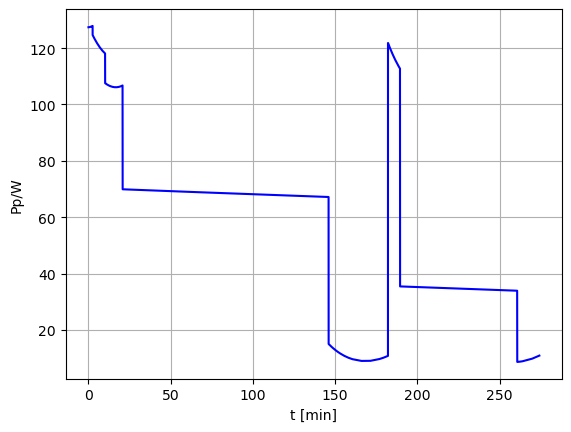

In [68]:
plt.plot(times/60,[myaircraft.performance.PoWTO(myaircraft.DesignWTOoS,beta[t],myaircraft.mission.profile.PowerExcess(times[t]),1,myaircraft.mission.profile.Altitude(times[t]),myaircraft.mission.DISA,myaircraft.mission.profile.Velocity(times[t]),'TAS') for t in range(len(times))], 'b')
plt.grid(visible=True)
plt.xlabel('t [min]')
plt.ylabel('Pp/W')
plt.show()

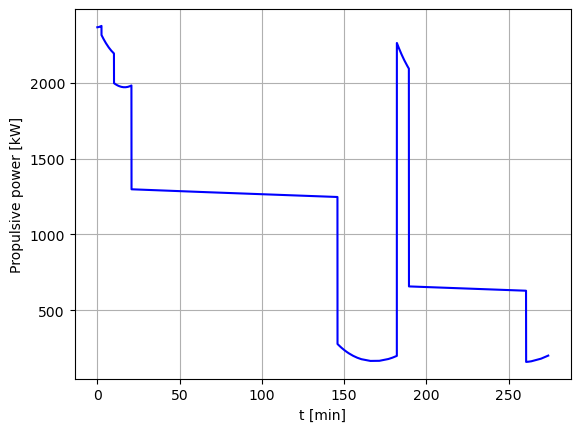

In [69]:
plt.plot(times/60,[(myaircraft.weight.WTO/1000) * myaircraft.performance.PoWTO(myaircraft.DesignWTOoS,beta[t],myaircraft.mission.profile.PowerExcess(times[t]),1,myaircraft.mission.profile.Altitude(times[t]),myaircraft.mission.DISA,myaircraft.mission.profile.Velocity(times[t]),'TAS') for t in range(len(times))], 'b')
# pwsd[t]= 1e-3*0.5*0.89*(myaircraft.weight.WTO/1000) * myaircraft.performance.PoWTO(myaircraft.DesignWTOoS,beta[t],myaircraft.mission.profile.PowerExcess(times[t]),1,myaircraft.mission.profile.Altitude(times[t]),myaircraft.mission.DISA,myaircraft.mission.profile.Velocity(times[t]),'TAS') for t in range(len(times))
plt.grid(visible=True)
plt.xlabel('t [min]')
plt.ylabel('Propulsive power [kW]')
plt.show()

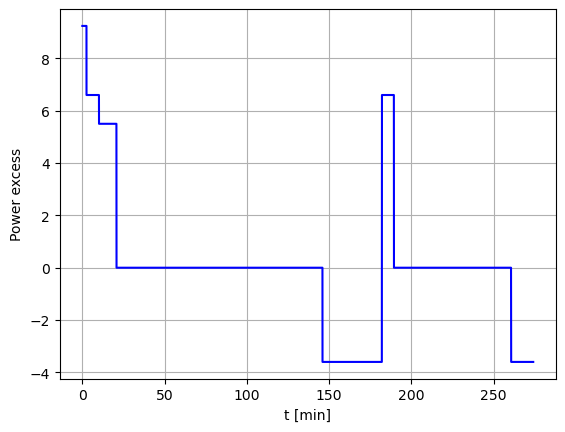

In [70]:
plt.plot(times/60,[myaircraft.mission.profile.PowerExcess(times[t]) for t in range(len(times))], 'b')
# pwsd[t]= 1e-3*0.5*0.89*(myaircraft.weight.WTO/1000) * myaircraft.performance.PoWTO(myaircraft.DesignWTOoS,beta[t],myaircraft.mission.profile.PowerExcess(times[t]),1,myaircraft.mission.profile.Altitude(times[t]),myaircraft.mission.DISA,myaircraft.mission.profile.Velocity(times[t]),'TAS') for t in range(len(times))
plt.grid(visible=True)
plt.xlabel('t [min]')
plt.ylabel('Power excess')
plt.show()

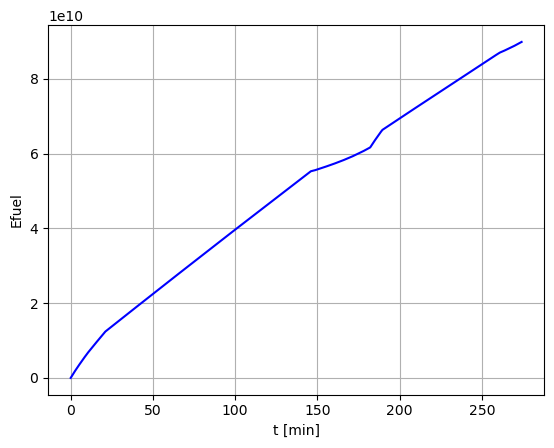

In [71]:
plt.plot(times/60,Ef, 'b')
#plt.plot(myaircraft.mission.profile.Breaks,np.ones(6)*0.05, '*')
plt.grid(visible=True)
plt.xlabel('t [min]')
plt.ylabel('Efuel')
plt.show()

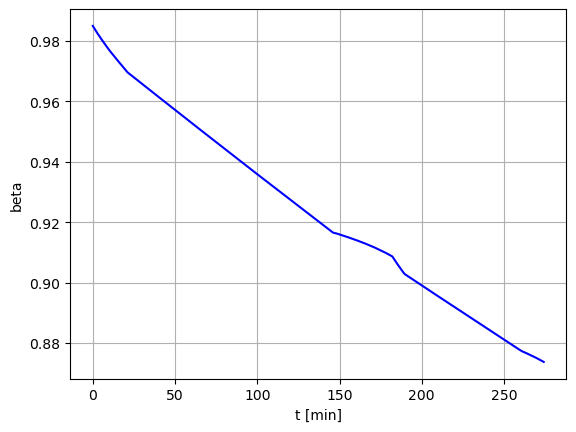

In [72]:
plt.plot(times/60,beta, 'b')
#plt.plot(myaircraft.mission.profile.Breaks,np.ones(6)*0.05, '*')
plt.grid(visible=True)
plt.xlabel('t [min]')
plt.ylabel('beta')
plt.show()

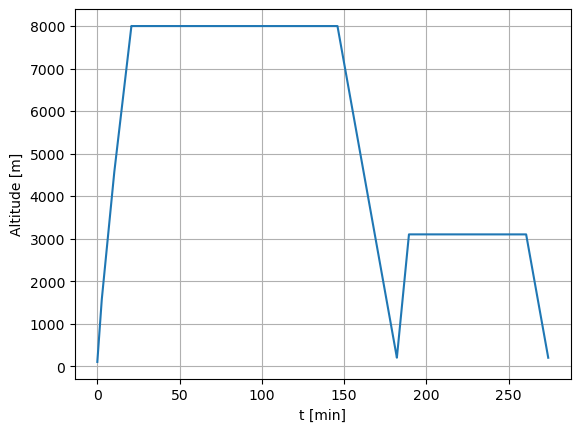

In [73]:
plt.plot(times/60,mission.profile.Altitude(times))
plt.grid(visible=True)
plt.xlabel('t [min]')
plt.ylabel('Altitude [m]')
plt.show()

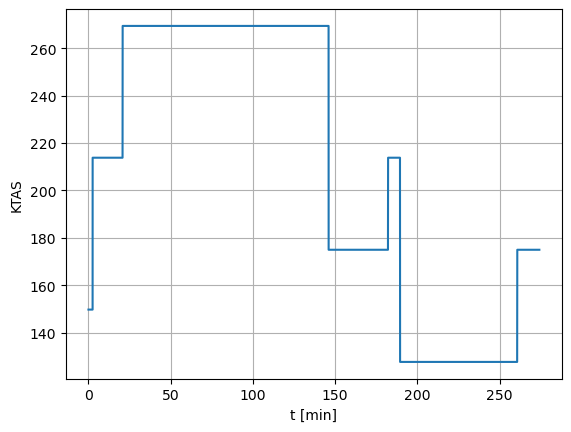

In [74]:
plt.plot(times/60,pg.Utilities.Units.MtoKN(mission.profile.Velocity(times)))
plt.grid(visible=True)
plt.xlabel('t [min]')
plt.ylabel('KTAS')
plt.show()

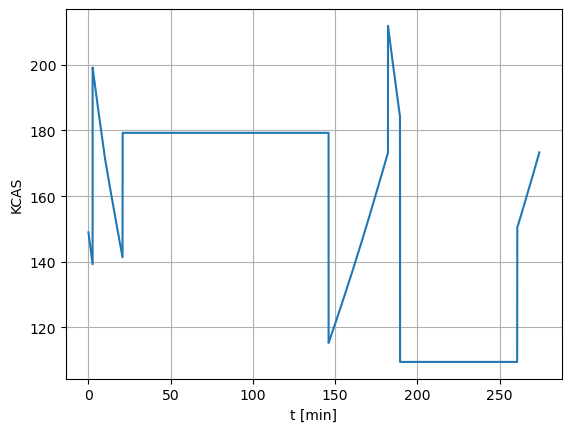

In [75]:
plt.plot(times/60,[pg.Utilities.Units.MtoKN(pg.Utilities.Speed.TAS2CAS(mission.profile.Velocity(t),mission.profile.Altitude(t))) for t in times])
plt.grid(visible=True)
plt.xlabel('t [min]')
plt.ylabel('KCAS')
plt.show()

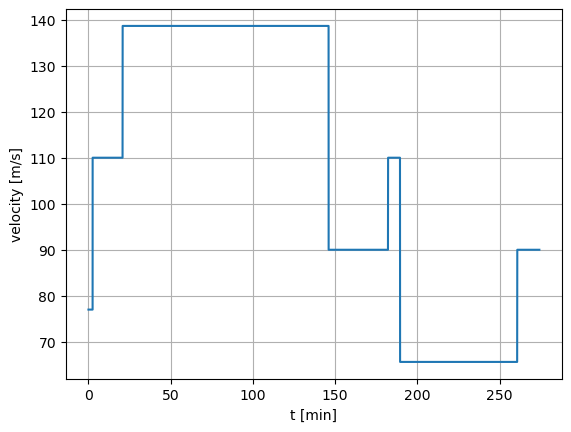

In [76]:
plt.plot(times/60,mission.profile.Velocity(times))
plt.grid(visible=True)
plt.xlabel('t [min]')
plt.ylabel('velocity [m/s]')
plt.show()

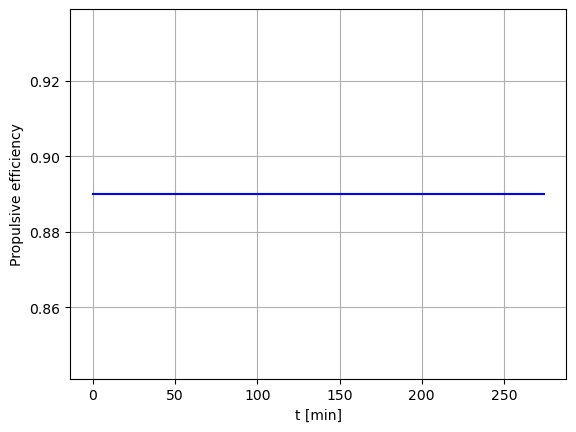

In [77]:
etaPP = np.zeros(len(times))
for t in range(len(times)):
    alt = myaircraft.mission.profile.Altitude(times[t])
    v = myaircraft.mission.profile.Velocity(times[t])
    power = (myaircraft.weight.WTO) * myaircraft.performance.PoWTO(myaircraft.DesignWTOoS,beta[t],myaircraft.mission.profile.PowerExcess(times[t]),1,alt,myaircraft.mission.DISA,v,'TAS')
    etaPP[t]= myaircraft.powertrain.EtaPPpw127Model(alt, v, power)
plt.plot(times/60,etaPP, 'b')
plt.grid(visible=True)
plt.xlabel('t [min]')
plt.ylabel('Propulsive efficiency')
plt.show()

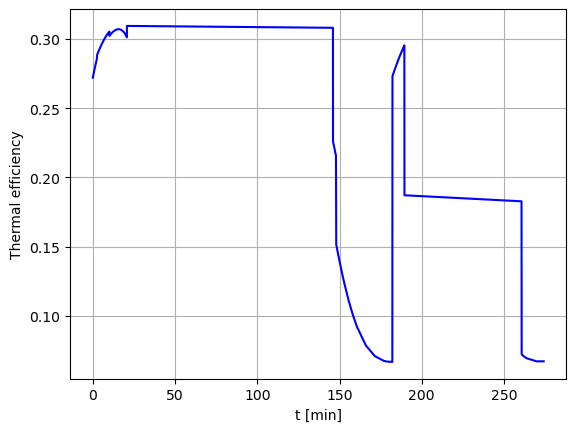

In [78]:
if myaircraft.EnergyInput['Eta Gas Turbine Model'] == 'PW127':
    etaTh = np.zeros(len(times))
    for t in range(len(times)):
        alt = myaircraft.mission.profile.Altitude(times[t])
        v = myaircraft.mission.profile.Velocity(times[t])
        power = (myaircraft.weight.WTO) * myaircraft.performance.PoWTO(myaircraft.DesignWTOoS,beta[t],myaircraft.mission.profile.PowerExcess(times[t]),1,alt,myaircraft.mission.DISA,v,'TAS')
        etaTh[t]= myaircraft.powertrain.EtaGTpw127Model(alt, v, power)
    plt.plot(times/60,etaTh, 'b')
    plt.grid(visible=True)
    plt.xlabel('t [min]')
    plt.ylabel('Thermal efficiency')
    plt.show()

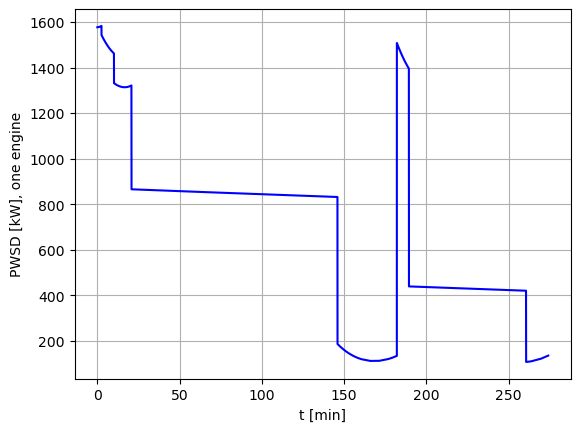

In [79]:
pwsd = np.zeros(len(times))
for t in range(len(times)):
    alt = myaircraft.mission.profile.Altitude(times[t])
    v = myaircraft.mission.profile.Velocity(times[t])
    power = (myaircraft.weight.WTO) * myaircraft.performance.PoWTO(myaircraft.DesignWTOoS,beta[t],myaircraft.mission.profile.PowerExcess(times[t]),1,alt,myaircraft.mission.DISA,v,'TAS')
    pwsd[t]= 1e-3*(1/myaircraft.performance.n_engines)*power/myaircraft.powertrain.EtaPP
plt.plot(times/60,pwsd, 'b')
plt.grid(visible=True)
plt.xlabel('t [min]')
plt.ylabel('PWSD [kW], one engine')
plt.show()

Compute Payload - Range diagram


In [80]:
from scipy.optimize import brenth 

In [81]:
maxFuelCapacity = 4000 #Kg (4000 + final reserve)
MTOW = myaircraft.weight.WTO #Kg
OEW = myaircraft.weight.WPT + myaircraft.weight.WStructure + myaircraft.weight.WCrew + myaircraft.weight.final_reserve #Kg 
MZFW =OEW + myaircraft.weight.WPayload #Kg 
WPayload = 4560 #Kg
wfuel = myaircraft.weight.Wf
designRange = 750 #nm

drng = 10 #nm

In [82]:
def funcNL(Wf, WPayload):
     return Wf - myaircraft.mission.EvaluateMission(OEW + WPayload+ Wf)/myaircraft.weight.ef

In [83]:
#1 non-limited range
missionRangeNL = np.linspace(150,designRange,num=50, endpoint=True) 
wfuelNL = []
for rng in missionRangeNL:
    newmission = pg.Mission.Mission(myaircraft)
    myaircraft.mission = newmission
    myaircraft.MissionInput['Range Mission'] = rng
    myaircraft.mission.InitializeProfile()
    myaircraft.mission.SetInput()
    wfuelNL.append(brenth(funcNL, 0, maxFuelCapacity, args=(WPayload), xtol=0.01) )

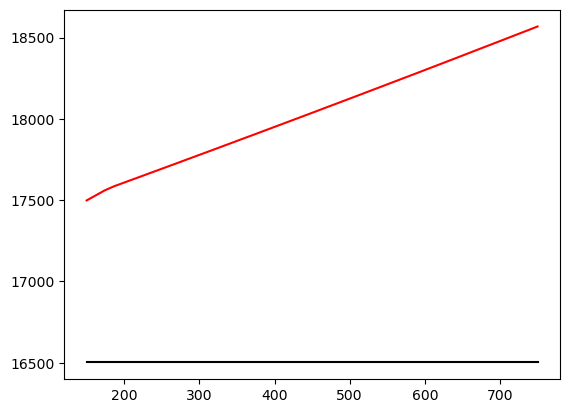

In [84]:
plt.plot(missionRangeNL,[MZFW for i in range(len(missionRangeNL))],color='black',label='OEW+Payload')
plt.plot(missionRangeNL,np.add(MZFW,wfuelNL),color='red',label='TOW')

In [85]:
def funcTOL(WPayload, MTOW):
     return MTOW - (OEW + WPayload + myaircraft.mission.EvaluateMission(MTOW)/myaircraft.weight.ef)

In [86]:
#2 - MTOW-limited range
rng = designRange
wpayloadTOL = []
wfuelTOL = []
missionRangeTOL = []
while wfuel < maxFuelCapacity:
    newmission = pg.Mission.Mission(myaircraft)
    myaircraft.mission = newmission
    myaircraft.MissionInput['Range Mission'] = rng
    myaircraft.mission.InitializeProfile()
    myaircraft.mission.SetInput()
    wpayloadTOL.append( brenth(funcTOL, 0, MTOW, args=(MTOW), xtol=0.01) )
    missionRangeTOL.append(rng)
    wfuel = MTOW - ( wpayloadTOL[-1] + OEW) 
    wfuelTOL.append(wfuel)
    rng = rng + drng

In [87]:
def funcFCL(WPayload, OEW, maxFuelCapacity):
     return maxFuelCapacity - myaircraft.mission.EvaluateMission(OEW+WPayload+maxFuelCapacity)/myaircraft.weight.ef

In [88]:
#3 - Fuel capacity-limited range
wpload = wpayloadTOL[-1]
rng = missionRangeTOL[-1]
wpayloadFCL = []
missionRangeFCL = []
while wpload > 300:
    newmission = pg.Mission.Mission(myaircraft)
    myaircraft.mission = newmission
    myaircraft.MissionInput['Range Mission'] = rng
    myaircraft.mission.InitializeProfile()
    myaircraft.mission.SetInput()
    wpayloadFCL.append(brenth(funcFCL, 0, WPayload, args=(OEW, maxFuelCapacity), xtol=0.01) )
    wpload = wpayloadFCL[-1] 
    missionRangeFCL.append(rng)
    rng = rng + drng

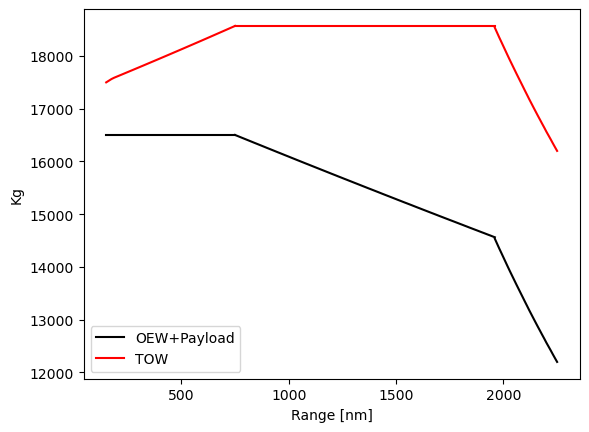

In [89]:
plt.plot(missionRangeNL,[MZFW for i in range(len(missionRangeNL))],color='black',label='OEW+Payload')
plt.plot(missionRangeNL,np.add(MZFW,wfuelNL),color='red',label='TOW')
plt.plot(missionRangeTOL,np.subtract(MTOW,wfuelTOL),color='black')
plt.plot(missionRangeTOL,[MTOW for i in range(len(missionRangeTOL))],color='red')
plt.plot(missionRangeFCL,np.add(OEW,wpayloadFCL),color='black')
plt.plot(missionRangeFCL,np.add(OEW+maxFuelCapacity,wpayloadFCL),color='red')
plt.xlabel('Range [nm]')
plt.ylabel('Kg')
plt.legend()